# Delayed tasks analysis


### Convert notebook to python
```
bash
jupyter nbconvert "D:\OneDrive - Nexus365\Private_Dropbox\Projects\trialexp\notebooks\noncanonical\nb20230202_145400_delayed_tasks_and_316_photometry.ipynb" --to="python" --output-dir="D:\OneDrive - Nexus365\Private_Dropbox\Projects\trialexp\notebooks\noncanonical" --output="nb20230202_145400_delayed_tasks_and_316_photometry"
```

Quick analysis of instrumental reaching

In [62]:
# allow for automatic reloading of classes and function when updating the code
%load_ext autoreload
%autoreload 2 

# Import Session and Experiment class with helper functions
from trialexp.process.data_import import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Variables

In [63]:
import pandas as pd
from pathlib import Path
trial_window = [-2000, 4000] # in ms

# time limit around trigger to perform an event
# determine successful trials
# timelim = [1000, 4000] # in ms

# Digital channel nb of the pyphotometry device
# on which rsync signal is sent (from pycontrol device)
rsync_chan = 2

basefolder = Path(os.getcwd()).parent.parent

# These must be absolute paths
# use this to use within package tasks files (in params)
tasksfile = Path(basefolder,'params','tasks_params.csv')
# use this to put a local full path
#tasksfile = -r'C:/.../tasks_params.csv' 

# from sample_data

# # From jade
# photometry_dir = Path('/home/MRC.OX.AC.UK/phar0732/ettin/Data/head-fixed/photometry')
# pycontrol_dir = Path('/home/MRC.OX.AC.UK/phar0732/ettin/Data/head-fixed/pycontrol')

# From julien-pc
photometry_dir = r'\\ettin\Magill_Lab\Julien\Data\head-fixed\pyphotometry\data\reaching_go_spout_bar_nov22'
pycontrol_dir = r'\\ettin\Magill_Lab\Julien\Data\head-fixed\pycontrol\reaching_go_spout_bar_nov22'

#From laptop
# photometry_dir = r'C:\Users\phar0732\Documents\GitHub\trialexp\sample_data\pyphotometry\reaching_go_spout_incr_break2_nov22'
# pycontrol_dir = r'C:\Users\phar0732\Documents\GitHub\trialexp\sample_data\pycontrol\reaching_go_spout_incr_break2_nov22'

video_dir = r'\\ettin\Magill_Lab\Julien\Data\head-fixed\videos'
tasks = pd.read_csv(tasksfile, usecols=[1, 2, 3, 4], index_col=False)


### Create an experiment object


In [64]:
# Load all raw text sessions in the indicated folder or a sessions.pkl file
# if already existing in folder_path
exp_cohort = Experiment(path=pycontrol_dir, int_subject_IDs=True, update=True, verbose=True)

Saved sessions loaded from: sessions.pkl
Unable to import file: v-2022-11-26-150859.txt
invalid literal for int() with base 10: ''
session nb:  1 0 2022-11-19 17:58:51 reaching_go_spout_bar_nov22
session nb:  2 0 2022-11-19 17:59:45 reaching_go_spout_bar_nov22
session nb:  3 0 2022-11-19 18:10:19 reaching_go_spout_bar_nov22
session nb:  4 0 2022-11-19 18:17:41 reaching_go_spout_bar_nov22
session nb:  5 0 2022-11-19 18:19:36 reaching_go_spout_bar_nov22
session nb:  6 0 2022-11-19 18:25:34 reaching_go_spout_bar_nov22
session nb:  7 0 2022-11-19 18:26:09 reaching_go_spout_bar_nov22
session nb:  8 0 2022-11-19 18:26:36 reaching_go_spout_bar_nov22
session nb:  9 0 2022-11-19 18:35:34 reaching_go_spout_bar_nov22
session nb:  10 0 2022-11-19 18:38:56 reaching_go_spout_bar_nov22
session nb:  11 0 2022-11-19 18:40:03 reaching_go_spout_bar_nov22
session nb:  12 0 2022-11-19 18:41:07 reaching_go_spout_bar_nov22
session nb:  13 0 2022-11-21 14:00:02 reaching_go_spout_nov22
session nb:  14 0 2022-1

Expressions like the following can help reduces the amount of sessions (for example for animals to not consider, or dates or etc)
- Here it won't consider subject_ID below 50, discarding for instance "test sessions" were subject_ID was 00 or 001 or the likes

In [65]:
exp_cohort.sessions = [session for session in exp_cohort.sessions if (session.subject_ID == 604)]

### Perform extraction of behavioural information by trial

In [66]:
# Process the whole experimental folder by trials

trial_window = [-2000,4000]
exp_cohort.process_exp_by_trial(trial_window, timelim=None, tasksfile=tasksfile, verbose=True)

# Save the file as sessions.pkl in folder_path
# exp_cohort.save()

processing by trial: RE604-2023-03-14-092522.txt task: reaching_go_spout_bar_mar23
processing by trial: RE604-2023-03-14-093001.txt task: reaching_go_spout_bar_mar23
processing by trial: RE604-2023-03-15-114819.txt task: reaching_go_spout_bar_mar23
processing by trial: RE604-2023-03-16-102419.txt task: reaching_go_spout_bar_mar23
processing by trial: RE604-2023-03-17-090113.txt task: reaching_go_spout_bar_mar23
processing by trial: RE604-2023-03-20-094835.txt task: reaching_go_spout_bar_mar23
processing by trial: RE604-2023-03-21-154547.txt task: reaching_go_spout_bar_mar23
processing by trial: RE604-2023-03-22-120336.txt task: reaching_go_spout_bar_mar23
processing by trial: RE604-2023-03-23-090342.txt task: reaching_go_spout_bar_mar23
processing by trial: RE604-2023-03-24-091134.txt task: reaching_go_spout_bar_mar23
processing by trial: RE604-2023-03-27-091207.txt task: reaching_go_spout_bar_mar23
processing by trial: RE604-2023-03-29-091133.txt task: reaching_go_spout_bar_mar23
proc

In [74]:
len(exp_cohort.sessions)

10

### Hacking of conditions for the task with no clear trial structure (first instrumental reaching phase)

In [67]:
# Defime each trial type as a dictionary of conditions to be met
conditions_dict1 = {'trigger': 'hold_for_water', 'success': True}

conditions_dict2 = {'trigger': 'hold_for_water', 'success': False}



# conditions_dict2 = {'trigger': 'hold_for_water', 'spout':False, 'valid': True, 'busy_win_timer': False, 'button_press': False}

# Aggregate all condition dictionaries in a list
conditions_list = [conditions_dict1, conditions_dict2]
# Aliases for conditions
cond_aliases = ['success', 'failed']
# Groups as a list of lists
# groups = [[280, 281, 282, 289],[295, 282, 284, 285, 292, 297]]
groups = None


## Match and synchronize photometry to behaviour

In [68]:
# Find if there is a matching photometry file:
exp_cohort.match_sessions_to_files(photometry_dir, ext='ppd')

# rsync synchronization pulses matching between behaviour and photometry
exp_cohort.sync_photometry_files(2)
exp_cohort.save()


c:\users\phar0732\documents\github\trialexp\trialexp\utils\rsync.py:78: RuntimeWarning: invalid value encountered in log
  log_mse = np.log(chunk_mse)
c:\users\phar0732\documents\github\trialexp\trialexp\utils\rsync.py:78: RuntimeWarning: invalid value encountered in log
  log_mse = np.log(chunk_mse)


saved \\ettin\Magill_Lab\Julien\Data\head-fixed\pycontrol\reaching_go_spout_bar_nov22\sessions.pkl


Loop to plot photometry trials triggered on different events
- 1: Trial onset (CS-onset = hold period start)
- 2: First bar_off
- 3: Last bar_off before spout
- 4: First spout
- 5: Reward (US_end_timer)

In [69]:
photo_dataset = exp_cohort.get_photometry_groups(
        groups = None, # or use groups variable defined above
        conditions_list = conditions_list, 
        cond_aliases = cond_aliases,
        trial_window = trial_window,
        when = 'all', 
        task_names = ['reaching_go_spout_bar_mar23'],
        trig_on_ev = None, # align to the first event of a kind e.g. bar_off
        last_before = None,
        baseline_low_pass = 0.001, 
        low_pass = 10, 
        median_filt = 3,
        motion_corr = True, 
        df_over_f = True,
        z_score = True, 
        downsampling_factor = 10, 
        export_vars = ['analog_1_df_over_f', 'zscored_df_over_f'], 
        # remove_artifacts = False, # To Deprecate in favor of Exp level artifact clustering
        verbose = True) # will plot all the process of remove_artifacts if remove_artifacts == True



Processing subject 604 at: 2023-03-14 09:25:22
condition 0 trials: 5
condition 1 trials: 3
Processing subject 604 at: 2023-03-15 11:48:19
condition 0 trials: 40
condition 1 trials: 98
Processing subject 604 at: 2023-03-16 10:24:19
condition 0 trials: 36
condition 1 trials: 224
Processing subject 604 at: 2023-03-17 09:01:13
condition 0 trials: 13
condition 1 trials: 37
Processing subject 604 at: 2023-03-20 09:48:35
condition 0 trials: 37
condition 1 trials: 413
Processing subject 604 at: 2023-03-21 15:45:47
condition 0 trials: 69
condition 1 trials: 203
Processing subject 604 at: 2023-03-22 12:03:36
condition 0 trials: 124
condition 1 trials: 101
Processing subject 604 at: 2023-03-23 09:03:42
condition 0 trials: 113
condition 1 trials: 183
Processing subject 604 at: 2023-03-24 09:11:34
condition 0 trials: 101
condition 1 trials: 228
Processing subject 604 at: 2023-03-27 09:12:07
condition 0 trials: 81
condition 1 trials: 229
Processing subject 604 at: 2023-03-29 09:11:33
condition 0 tri

Plot photometry trials triggered on different events based on above extraction
- 1: Trial onset (CS-onset = hold period start)
- 2: First bar_off
- 3: Last bar_off before spout
- 4: First spout
- 5: Reward (US_end_timer)

cond_ID: 0, group_idx 0, subj 604
cond_ID: 1, group_idx 0, subj 604


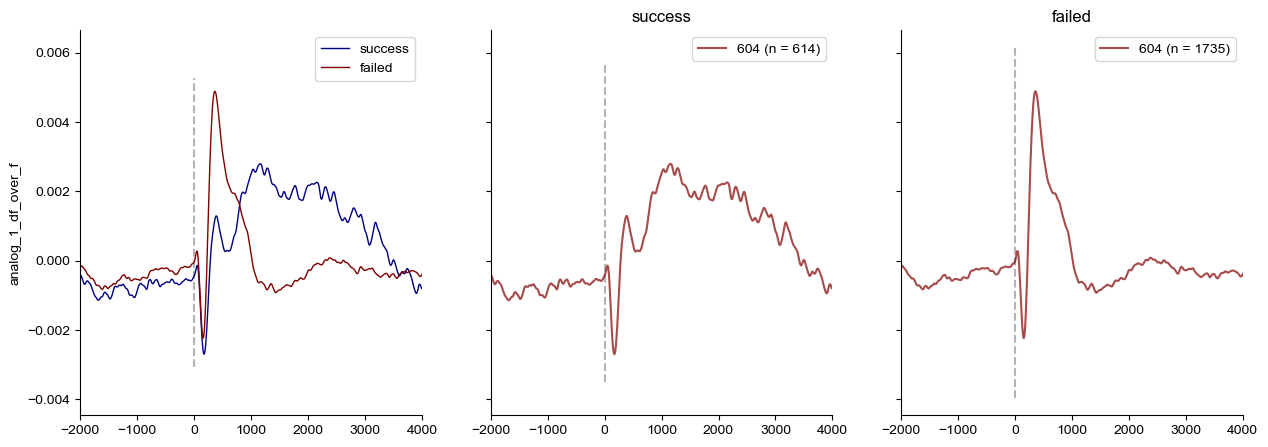

In [70]:
photo_dataset.filter_reset()
photo_dataset.filterout_subjects([60]) # remove kms060
photo_dataset.filter_min_by_session(min_trials = 10)
# photo_dataset.filter_lastNsessions(n = 1)

fig = photo_dataset.lineplot(
    vars = ['analog_1_df_over_f'],
    time_lim = [-2000, 4000],
    # time_unit = 'seconds',
    ylim = None,# [[-1, 5]],# [[-0.004, 0.006]],#[[-0.03, 0.1]],#,[-0.005, 0.007]],#[[-0.001, 0.0011],[-0.001, 0.0011]],
    error = True,
    colormap = 'jet',
    legend = True,
    plot_subjects = True,
    plot_groups = True,
    liney0 = False,
    linex0 = True,
    figsize = (15, 5),
    dpi = 100,
    verbose = True)

Same plot, heatmap version:

- 1: Trial onset (CS-onset = hold period start)
- 2: First bar_off
- 3: Last bar_off before spout
- 4: First spout
- 5: Reward (US_end_timer)

In [89]:
photo_dataset.filter_reset()
photo_dataset.filterout_subjects([0,1,61,63,313,314,315,317,318])
photo_dataset.filterout_dates([datetime(2023,2,24).date(), datetime(2023,2,23).date()])
photo_dataset.filter_lastNsessions(n = 1)
figs, subject_IDs = photo_dataset.heatmap(
    vars = ['zscored_df_over_f'],
    time_lim = [-500, 500],
    clim_pctile = None,
    colormap = 'jet'
)   
photo_dataset.filter_reset()


for f_idx, fig in enumerate(figs): 
    
    # You can customize this to save figures elsewhere 
    file_path = 'C:\\Users\\phar0732\\Documents\\GitHub\\trialexp\\outputs\\' + 'photo_heatmap_' + str(subject_IDs[f_idx]) + '.pdf'
    fig.savefig(file_path)

['empty fig', 'empty fig', 'empty fig', 'empty fig']
0
1
2
3
